In [1]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [3]:
data=pd.read_csv("tpm_data.csv", header=0)
data

,Unnamed: 0,ENSG,hgnc_symbol,gene_length,C_0002,C_0003,C_0004,C_0005,C_0006,C_0008,...,H_0740,H_0750,H_0513,H_0601,H_0656,H_0689,H_0709,H_0723,H_1104,H_1105
0,1,ENSG00000000003,TSPAN6,12883,2.703162,4.679815,3.827170,3.940771,3.956139,4.749555,...,4.799810,8.733498,3.666497,4.563176,2.492904,2.949728,3.314066,6.985665,3.947979,3.784485
1,2,ENSG00000000005,TNMD,14949,0.005418,0.029438,0.088121,0.036995,0.053272,0.108531,...,0.024476,0.086370,0.083015,0.078651,0.050749,0.014444,0.028001,0.138079,0.031214,0.064583
2,3,ENSG00000000419,DPM1,24273,2.625862,4.387499,4.450224,5.390720,3.707350,5.356800,...,4.100151,6.470481,5.783705,6.878268,3.167153,1.530000,6.380522,8.912018,6.420788,9.267549
3,4,ENSG00000000457,SCYL3,44636,0.896318,1.025353,1.568379,1.315815,1.617599,1.350063,...,0.610696,0.892573,1.098204,1.589228,0.708180,0.416006,0.628301,1.156094,1.317197,2.011547
4,5,ENSG00000000460,C1orf112,192073,0.033732,0.123724,0.065645,0.074862,0.063574,0.114637,...,0.030003,0.052817,0.036344,0.091820,0.025015,0.042717,0.034868,0.060181,0.072882,0.070371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21858,26560,ENSG00000273372,SFTPD-AS1,5000,0.680299,0.616103,0.715117,1.061834,1.061811,1.437003,...,0.311009,0.202893,0.201662,1.018982,0.050577,0.647750,0.000000,0.247696,0.559947,0.096546
21859,26565,ENSG00000273396,LINC01396,6639,0.036596,0.066286,0.226767,0.049981,0.119952,0.139644,...,0.013778,0.027783,0.000000,0.000000,0.038090,0.000000,0.000000,0.000000,0.000000,0.000000
21860,26570,ENSG00000273409,LINC02712,66004,0.019632,0.040004,0.068428,0.016758,0.036196,0.017558,...,0.005544,0.027945,0.054055,0.065315,0.015325,0.009814,0.000000,0.012509,0.028278,0.058509
21861,26571,ENSG00000273415,LINC02725,87913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [4]:
dataX_pre=data.iloc[:,4:]
dataX=dataX_pre.T
dataX_min=np.min(dataX.values[dataX.values>0])
dataX_min

8.621517048846005e-05

In [5]:
#convert 0 into minimized number which cannot affect analysis
convert_num = 8.621517048846005e-06
dataX[dataX== 0] = convert_num

In [6]:
dataX_copy=dataX.copy()
dataX_copy_log=dataX_copy.apply(np.log)

In [7]:
#delete a column which has a smallest std (deleting LINC02694)
dataX_after_del=dataX_copy.drop(dataX_copy.columns[13609],axis=1)
dataX_after_del

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,2.703162,0.005418,2.625862,0.896318,0.033732,1.520210,0.668186,2.390171,1.079804,1.846578,...,1.024701,0.000009,0.007266,12.989309,2.596021,0.680299,0.036596,0.019632,0.000009,0.417913
C_0003,4.679815,0.029438,4.387499,1.025353,0.123724,2.417254,0.541779,6.715102,2.762668,5.757188,...,3.380591,0.400795,0.000009,42.426011,2.992243,0.616103,0.066286,0.040004,0.000009,0.416324
C_0004,3.827170,0.088121,4.450224,1.568379,0.065645,1.855760,0.840779,4.118158,1.709962,3.075835,...,1.955870,0.171392,0.008442,24.410100,2.010758,0.715117,0.226767,0.068428,0.000009,0.716177
C_0005,3.940771,0.036995,5.390720,1.315815,0.074862,1.803517,1.254086,5.239934,2.649874,4.998753,...,3.698587,0.201471,0.000009,24.525642,3.975217,1.061834,0.049981,0.016758,0.000009,0.516058
C_0006,3.956139,0.053272,3.707350,1.617599,0.063574,1.354761,0.569268,4.474453,2.367638,4.753598,...,0.719709,0.000009,0.000009,33.152522,1.418155,1.061811,0.119952,0.036196,0.000009,0.388106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,2.949728,0.014444,1.530000,0.416006,0.042717,4.108964,1.871441,2.094295,0.747223,2.215735,...,0.487837,0.196645,0.009686,9.461733,2.411892,0.647750,0.000009,0.009814,0.000009,0.102132
H_0709,3.314066,0.028001,6.380522,0.628301,0.034868,1.158647,0.860249,3.787714,1.060191,1.706804,...,0.945729,0.000009,0.000009,31.182523,3.252682,0.000009,0.000009,0.000009,0.000009,0.890978
H_0723,6.985665,0.138079,8.912018,1.156094,0.060181,1.946203,1.799320,4.370479,1.842778,3.689338,...,2.425103,1.503924,0.018520,57.708965,6.215465,0.247696,0.000009,0.012509,0.000009,0.781096
H_1104,3.947979,0.031214,6.420788,1.317197,0.072882,2.361264,1.357402,3.256530,1.497821,3.361442,...,2.319405,0.000009,0.000009,24.742013,3.172758,0.559947,0.000009,0.028278,0.000009,0.642094


In [8]:
#delete a column which has a smallest std
dataX_after_del2=dataX_after_del.drop(dataX_copy.columns[19081],axis=1)
dataX_after_del2

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,2.703162,0.005418,2.625862,0.896318,0.033732,1.520210,0.668186,2.390171,1.079804,1.846578,...,1.024701,0.000009,0.007266,12.989309,2.596021,0.680299,0.036596,0.019632,0.000009,0.417913
C_0003,4.679815,0.029438,4.387499,1.025353,0.123724,2.417254,0.541779,6.715102,2.762668,5.757188,...,3.380591,0.400795,0.000009,42.426011,2.992243,0.616103,0.066286,0.040004,0.000009,0.416324
C_0004,3.827170,0.088121,4.450224,1.568379,0.065645,1.855760,0.840779,4.118158,1.709962,3.075835,...,1.955870,0.171392,0.008442,24.410100,2.010758,0.715117,0.226767,0.068428,0.000009,0.716177
C_0005,3.940771,0.036995,5.390720,1.315815,0.074862,1.803517,1.254086,5.239934,2.649874,4.998753,...,3.698587,0.201471,0.000009,24.525642,3.975217,1.061834,0.049981,0.016758,0.000009,0.516058
C_0006,3.956139,0.053272,3.707350,1.617599,0.063574,1.354761,0.569268,4.474453,2.367638,4.753598,...,0.719709,0.000009,0.000009,33.152522,1.418155,1.061811,0.119952,0.036196,0.000009,0.388106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,2.949728,0.014444,1.530000,0.416006,0.042717,4.108964,1.871441,2.094295,0.747223,2.215735,...,0.487837,0.196645,0.009686,9.461733,2.411892,0.647750,0.000009,0.009814,0.000009,0.102132
H_0709,3.314066,0.028001,6.380522,0.628301,0.034868,1.158647,0.860249,3.787714,1.060191,1.706804,...,0.945729,0.000009,0.000009,31.182523,3.252682,0.000009,0.000009,0.000009,0.000009,0.890978
H_0723,6.985665,0.138079,8.912018,1.156094,0.060181,1.946203,1.799320,4.370479,1.842778,3.689338,...,2.425103,1.503924,0.018520,57.708965,6.215465,0.247696,0.000009,0.012509,0.000009,0.781096
H_1104,3.947979,0.031214,6.420788,1.317197,0.072882,2.361264,1.357402,3.256530,1.497821,3.361442,...,2.319405,0.000009,0.000009,24.742013,3.172758,0.559947,0.000009,0.028278,0.000009,0.642094


In [9]:
#log conversion of Dataframe
dataX_log_del2=dataX_after_del2.apply(np.log)
dataX_log_del2

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,0.994422,-5.218099,0.965409,-0.109460,-3.389303,0.418849,-0.403189,0.871365,0.076779,0.613334,...,0.024401,-11.661249,-4.924490,2.564127,0.953980,-0.385223,-3.307803,-3.930581,-11.661249,-0.872483
C_0003,1.543259,-3.525458,1.478759,0.025037,-2.089705,0.882632,-0.612896,1.904359,1.016197,1.750449,...,1.218051,-0.914304,-11.661249,3.747762,1.096023,-0.484341,-2.713775,-3.218770,-11.661249,-0.876291
C_0004,1.342126,-2.429044,1.492955,0.450043,-2.723493,0.618294,-0.173427,1.415406,0.536471,1.123576,...,0.670835,-1.763801,-4.774493,3.194997,0.698512,-0.335309,-1.483830,-2.681972,-11.661249,-0.333828
C_0005,1.371376,-3.296972,1.684679,0.274456,-2.592106,0.589739,0.226407,1.656309,0.974512,1.609188,...,1.307951,-1.602108,-11.661249,3.199719,1.380079,0.059998,-2.996114,-4.088895,-11.661249,-0.661535
C_0006,1.375269,-2.932350,1.310317,0.480943,-2.755552,0.303625,-0.563404,1.498384,0.861893,1.558902,...,-0.328908,-11.661249,-11.661249,3.501119,0.349357,0.059976,-2.120667,-3.318809,-11.661249,-0.946478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,1.081713,-4.237507,0.425267,-0.877056,-3.153152,1.413171,0.626709,0.739217,-0.291392,0.795584,...,-0.717774,-1.626353,-4.637045,2.247256,0.880411,-0.434250,-11.661249,-4.623965,-11.661249,-2.281487
H_0709,1.198176,-3.575533,1.853250,-0.464737,-3.356175,0.147253,-0.150534,1.331763,0.058449,0.534623,...,-0.055800,-11.661249,-11.661249,3.439858,1.179480,-11.661249,-11.661249,-11.661249,-11.661249,-0.115436
H_0723,1.943860,-1.979933,2.187401,0.145047,-2.810397,0.665880,0.587409,1.474873,0.611274,1.305447,...,0.885874,0.408078,-3.988909,4.055413,1.827040,-1.395552,-11.661249,-4.381294,-11.661249,-0.247057
H_1104,1.373204,-3.466880,1.859541,0.275506,-2.618914,0.859197,0.305573,1.180662,0.404012,1.212370,...,0.841311,-11.661249,-11.661249,3.208503,1.154601,-0.579914,-11.661249,-3.565657,-11.661249,-0.443020


In [10]:
featuresToScale=dataX_log_del2.columns
sX=pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX_log_del2.loc[:, featuresToScale]=sX.fit_transform(dataX_log_del2)

In [11]:
dataX_C=dataX_log_del2.filter(like='C', axis=0)
dataX_C

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,-1.238669,-0.489755,-1.404819,-0.661768,-1.214104,-0.438326,-0.542205,-1.549951,-1.144974,-1.361823,...,-0.794664,-1.270403,0.737597,-1.819190,-0.178338,0.264969,0.721004,-0.094753,-0.349492,-0.142859
C_0003,-0.094326,0.128294,-0.400562,-0.392906,0.908731,0.454217,-0.792399,0.733360,0.611638,0.953743,...,0.767006,0.814752,-1.029937,0.719449,0.054000,0.220818,0.859050,0.298774,-0.349492,-0.149023
C_0004,-0.513695,0.528638,-0.372793,0.456696,-0.126533,-0.054497,-0.268084,-0.347413,-0.285398,-0.322790,...,0.051075,0.649930,0.776952,-0.466111,-0.596202,0.287203,1.144874,0.595544,-0.349492,0.728854
C_0005,-0.452707,0.211724,0.002274,0.105692,0.088081,-0.109452,0.208944,0.185074,0.533692,0.666086,...,0.884624,0.681302,-1.029937,-0.455983,0.518626,0.463286,0.793437,-0.182278,-0.349492,0.198520
C_0006,-0.444591,0.344861,-0.730082,0.518467,-0.178900,-0.660072,-0.733352,-0.164000,0.323106,0.563685,...,-1.256904,-1.270403,-1.029937,0.190454,-1.167309,0.463277,0.996881,0.243467,-0.349492,-0.262606
C_0008,-0.063484,0.604704,-0.010074,0.157058,0.784126,0.523687,0.705062,0.107073,0.650657,0.591910,...,0.626894,0.690349,-1.029937,-0.004865,0.357423,0.598058,1.032206,-0.156499,-0.349492,-0.711918
C_0009,-1.014420,0.027920,0.485191,1.511839,2.342554,-0.059718,-0.901242,2.952803,3.037081,1.972919,...,0.056384,1.073685,-1.029937,2.372708,1.781837,-4.757775,-1.220236,1.391432,-0.349492,-3.818267
C_0010,-1.071431,0.484398,-0.933368,-0.658817,-0.998986,-0.943378,-1.362364,-0.970939,-0.853908,-0.605820,...,-0.555258,-1.270403,0.785608,-0.303165,0.070641,0.277815,0.669304,0.071529,-0.349492,-0.462936
C_0011,-0.921800,0.182561,-2.304816,-1.383902,-1.199928,-0.621190,-1.538195,-1.155816,-0.558486,-0.865617,...,-1.144206,-1.270403,-1.029937,-1.399549,-1.752028,-0.121130,0.774877,0.128418,-0.349492,-0.916628
C_0012,0.370489,0.568469,0.573826,1.847973,2.247641,-1.047992,-1.840582,2.485153,2.363211,2.430353,...,1.381163,0.671095,0.987434,1.425060,0.034088,0.766789,0.848066,0.465206,-0.349492,0.968155


In [12]:
dataX_C['cluster']=1
dataX_P=dataX_log_del2.filter(like='P', axis=0)
dataX_P['cluster']=0
dataX_H=dataX_log_del2.filter(like='H',axis=0)
dataX_H['cluster']=2

/tmp/ipykernel_3372753/805336276.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX_C['cluster']=1
/tmp/ipykernel_3372753/805336276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataX_P['cluster']=0
/tmp/ipykernel_3372753/805336276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [13]:
dataX_cluster=pd.concat([dataX_C, dataX_P, dataX_H], ignore_index=False)
dataX_cluster

,0,1,2,3,4,5,6,7,8,9,...,21854,21855,21856,21857,21858,21859,21860,21861,21862,cluster
C_0002,-1.238669,-0.489755,-1.404819,-0.661768,-1.214104,-0.438326,-0.542205,-1.549951,-1.144974,-1.361823,...,-1.270403,0.737597,-1.819190,-0.178338,0.264969,0.721004,-0.094753,-0.349492,-0.142859,1
C_0003,-0.094326,0.128294,-0.400562,-0.392906,0.908731,0.454217,-0.792399,0.733360,0.611638,0.953743,...,0.814752,-1.029937,0.719449,0.054000,0.220818,0.859050,0.298774,-0.349492,-0.149023,1
C_0004,-0.513695,0.528638,-0.372793,0.456696,-0.126533,-0.054497,-0.268084,-0.347413,-0.285398,-0.322790,...,0.649930,0.776952,-0.466111,-0.596202,0.287203,1.144874,0.595544,-0.349492,0.728854,1
C_0005,-0.452707,0.211724,0.002274,0.105692,0.088081,-0.109452,0.208944,0.185074,0.533692,0.666086,...,0.681302,-1.029937,-0.455983,0.518626,0.463286,0.793437,-0.182278,-0.349492,0.198520,1
C_0006,-0.444591,0.344861,-0.730082,0.518467,-0.178900,-0.660072,-0.733352,-0.164000,0.323106,0.563685,...,-1.270403,-1.029937,0.190454,-1.167309,0.463277,0.996881,0.243467,-0.349492,-0.262606,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,-1.056665,-0.131702,-2.461487,-2.196218,-0.828361,1.475229,0.686531,-1.842048,-1.833416,-0.990698,...,0.676598,0.813014,-2.498809,-0.298672,0.243131,-1.220236,-0.478093,-0.349492,-2.423072,2
H_0709,-0.813836,0.110010,0.332046,-1.371978,-1.159991,-0.961007,-0.240771,-0.532297,-1.179250,-1.522107,...,-1.270403,-1.029937,0.059062,0.190509,-4.757775,-1.220236,-4.368677,-0.349492,1.082281,2
H_0723,0.740941,0.692626,0.985739,-0.153001,-0.268487,0.037081,0.639643,-0.215969,-0.145524,0.047562,...,1.071325,0.983066,1.379293,1.249711,-0.185067,-1.220236,-0.343931,-0.349492,0.869277,2
H_1104,-0.448897,0.149684,0.344353,0.107790,0.044293,0.409116,0.303394,-0.866286,-0.533084,-0.141975,...,-1.270403,-1.029937,-0.437144,0.149815,0.178247,-1.220236,0.106997,-0.349492,0.552147,2


In [14]:
dataX_log_del2

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0002,-1.238669,-0.489755,-1.404819,-0.661768,-1.214104,-0.438326,-0.542205,-1.549951,-1.144974,-1.361823,...,-0.794664,-1.270403,0.737597,-1.819190,-0.178338,0.264969,0.721004,-0.094753,-0.349492,-0.142859
C_0003,-0.094326,0.128294,-0.400562,-0.392906,0.908731,0.454217,-0.792399,0.733360,0.611638,0.953743,...,0.767006,0.814752,-1.029937,0.719449,0.054000,0.220818,0.859050,0.298774,-0.349492,-0.149023
C_0004,-0.513695,0.528638,-0.372793,0.456696,-0.126533,-0.054497,-0.268084,-0.347413,-0.285398,-0.322790,...,0.051075,0.649930,0.776952,-0.466111,-0.596202,0.287203,1.144874,0.595544,-0.349492,0.728854
C_0005,-0.452707,0.211724,0.002274,0.105692,0.088081,-0.109452,0.208944,0.185074,0.533692,0.666086,...,0.884624,0.681302,-1.029937,-0.455983,0.518626,0.463286,0.793437,-0.182278,-0.349492,0.198520
C_0006,-0.444591,0.344861,-0.730082,0.518467,-0.178900,-0.660072,-0.733352,-0.164000,0.323106,0.563685,...,-1.256904,-1.270403,-1.029937,0.190454,-1.167309,0.463277,0.996881,0.243467,-0.349492,-0.262606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0689,-1.056665,-0.131702,-2.461487,-2.196218,-0.828361,1.475229,0.686531,-1.842048,-1.833416,-0.990698,...,-1.765663,0.676598,0.813014,-2.498809,-0.298672,0.243131,-1.220236,-0.478093,-0.349492,-2.423072
H_0709,-0.813836,0.110010,0.332046,-1.371978,-1.159991,-0.961007,-0.240771,-0.532297,-1.179250,-1.522107,...,-0.899592,-1.270403,-1.029937,0.059062,0.190509,-4.757775,-1.220236,-4.368677,-0.349492,1.082281
H_0723,0.740941,0.692626,0.985739,-0.153001,-0.268487,0.037081,0.639643,-0.215969,-0.145524,0.047562,...,0.332414,1.071325,0.983066,1.379293,1.249711,-0.185067,-1.220236,-0.343931,-0.349492,0.869277
H_1104,-0.448897,0.149684,0.344353,0.107790,0.044293,0.409116,0.303394,-0.866286,-0.533084,-0.141975,...,0.274111,-1.270403,-1.029937,-0.437144,0.149815,0.178247,-1.220236,0.106997,-0.349492,0.552147


In [15]:
patient_num=dataX_cluster['cluster']
patient_num_array=patient_num.values
patient_num_array

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
X_train, X_test = train_test_split(dataX_cluster, test_size=0.05,random_state=2022)

In [17]:
def corre_plot(X_train, X_train_pred, X_test, X_test_pred):
    x=np.linspace(-2,10)
    y=x
    plt.figure(constrained_layout=True)
    plt.subplot(2,2,1)
    plt.title('train correlation')
    plt.scatter(X_train,X_train_pred,alpha=0.02,s=1)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,2)
    plt.title('test correlation')
    plt.scatter(X_test,X_test_pred,alpha=0.02,s=1)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,3)
    plt.title('train correlation narrow')
    plt.scatter(X_train,X_train_pred,alpha=0.02,s=1,c='black')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,4)
    plt.title('test correlation narrow')
    plt.scatter(X_test,X_test_pred,alpha=0.02,s=1,c='black')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot(x,y,color='green')
    plt.show()

In [18]:
def history_plot(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','eval'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','eval'],loc='upper right')
    plt.show()

In [19]:
def plot_feature_importance(df): 
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_importance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_importance_plot, align='center')
    cols_plot = df_plot['feature'].values             
    plt.yticks(np.arange(n_features), cols_plot)      
    plt.xlabel('Feature importance')                  
    plt.ylabel('Feature') 

In [20]:
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Input, Lambda
from keras.models import load_model

2025-06-03 19:10:45.520516: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [21]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        tf.config.set_soft_device_placement(True)
        growth = tf.config.experimental.get_memory_growth(device)
        print('{} memory growth: {}'.format(device, growth))
else:
    print("Not enough GPU hardware devices available.")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU') memory growth: True


2025-06-03 19:10:46.676481: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-06-03 19:10:46.677925: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-06-03 19:10:46.694882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-03 19:10:46.695697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2025-06-03 19:10:46.695798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-0

In [22]:
def corre_plot(X_train, X_train_pred, X_test, X_test_pred):
    x=np.linspace(-2,10)
    y=x
    plt.figure(constrained_layout=True)
    plt.subplot(2,2,1)
    plt.title('train correlation')
    plt.scatter(X_train,X_train_pred,alpha=0.02,s=1)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,2)
    plt.title('test correlation')
    plt.scatter(X_test,X_test_pred,alpha=0.02,s=1)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,3)
    plt.title('train correlation narrow')
    plt.scatter(X_train,X_train_pred,alpha=0.02,s=1,c='black')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot(x,y,color='green')
    plt.subplot(2,2,4)
    plt.title('test correlation narrow')
    plt.scatter(X_test,X_test_pred,alpha=0.02,s=1,c='black')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.plot(x,y,color='green')
    plt.show()

In [23]:
def history_plot(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','eval'], loc='upper right')
    plt.subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','eval'],loc='upper right')
    plt.show()

In [24]:
def plot_feature_importance(df): 
    n_features = len(df)
    df_plot = df.sort_values('importance')
    f_importance_plot = df_plot['importance'].values
    plt.barh(range(n_features), f_importance_plot, align='center')
    cols_plot = df_plot['feature'].values             
    plt.yticks(np.arange(n_features), cols_plot)      
    plt.xlabel('Feature importance')                  
    plt.ylabel('Feature') 

In [25]:
model20dims = load_model("model20_11_20dim.h5")
model20dims.summary()

2025-06-03 19:10:46.811029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-03 19:10:46.812149: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-06-03 19:10:46.934767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-03 19:10:46.935476: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2025-06-03 19:10

Model: "sequential_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_914 (Dense)            (None, 100)               2186200   
_________________________________________________________________
batch_normalization_693 (Bat (None, 100)               400       
_________________________________________________________________
dense_915 (Dense)            (None, 100)               10100     
_________________________________________________________________
batch_normalization_694 (Bat (None, 100)               400       
_________________________________________________________________
dense_916 (Dense)            (None, 20)                2020      
_________________________________________________________________
batch_normalization_695 (Bat (None, 20)                80        
_________________________________________________________________
dense_917 (Dense)            (None, 100)            

In [26]:
df_train = X_train.iloc[:, :-1]
df_test = X_test.iloc[:, :-1]

In [27]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
C_0083,0.388913,0.232071,1.041605,0.902932,0.923106,-1.479170,-0.725972,0.561737,1.005341,0.631400,...,0.753887,0.656740,-1.029937,0.344238,-0.614887,0.347417,-1.220236,0.130942,3.000866,0.672039
P_0014,-0.491357,-0.208702,-0.949570,-0.080523,0.650120,-0.477062,0.117402,-0.177543,-0.005107,0.238695,...,-0.227848,-1.270403,-1.029937,-0.623604,0.379853,0.394208,0.644572,0.454151,-0.349492,-1.281494
H_0006,1.007862,0.051293,0.647164,-0.520091,0.337481,1.187124,0.750467,-0.115304,-0.631415,-0.789085,...,-0.340969,0.852506,1.126368,0.267152,0.448367,-0.559285,-1.220236,0.912924,-0.349492,1.014469
C_0008,-0.063484,0.604704,-0.010074,0.157058,0.784126,0.523687,0.705062,0.107073,0.650657,0.591910,...,0.626894,0.690349,-1.029937,-0.004865,0.357423,0.598058,1.032206,-0.156499,-0.349492,-0.711918
P_0132,-0.379078,-0.063351,-0.422360,-1.034857,-0.855160,0.566042,-0.034787,-0.017356,-0.152592,-1.035450,...,-1.987399,0.712918,1.102537,0.679585,0.828777,-0.162848,-1.220236,0.291017,-0.349492,-1.054538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H_0012,-1.521997,0.067175,-0.349465,-1.227161,-1.159223,0.147176,0.480327,-1.637841,-1.043687,-0.477915,...,0.128161,0.782275,-1.029937,-1.323493,-0.181305,-0.492980,-1.220236,-4.368677,-0.349492,-1.423462
P_0015,-1.501659,-0.015775,-2.043978,-1.415894,-0.616190,-1.331602,-1.422446,-1.490010,-1.171014,-0.957152,...,-1.225591,-1.270403,-1.029937,-1.174205,0.032423,0.012057,-1.220236,-0.143522,-0.349492,-1.608102
C_0087,0.262581,0.557800,0.801761,0.796105,0.392620,-0.952609,0.115493,0.295912,0.798726,0.749829,...,0.412925,-1.270403,0.797906,0.189569,-1.457010,0.273234,0.680197,0.341713,-0.349492,1.079904
C_0050,1.048922,0.577184,1.692505,1.645615,0.750238,-0.066897,-0.130413,1.106432,1.015931,1.764417,...,1.333553,-1.270403,1.216004,0.990117,-0.753045,0.618545,1.050514,0.563625,2.764119,1.325121


In [28]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,21853,21854,21855,21856,21857,21858,21859,21860,21861,21862
P_0063,-0.354154,-0.443490,-0.519781,-0.938225,-0.692398,-1.225452,-0.567080,-0.929789,-0.391042,-0.918295,...,-1.361050,-1.270403,0.770840,-0.650630,0.148355,-0.417226,0.656224,-1.557539,-0.349492,-1.420660
P_0029,-0.495266,0.082892,-1.553595,-1.080348,-0.552315,1.010324,-0.309374,-1.022790,-0.761766,-0.485853,...,-0.872063,-1.270403,-1.029937,-1.033890,-0.783647,-0.293198,0.669075,-0.153178,-0.349492,0.354232
H_0010,0.947469,0.610187,1.167948,1.184255,0.972135,0.467329,1.196569,0.468982,0.605396,0.755573,...,1.017267,0.936328,1.164238,0.185686,-0.605207,0.286310,-1.220236,0.613593,-0.349492,1.488160
C_0025,-0.525737,0.242389,0.106966,0.424007,0.286912,-0.878035,-1.127625,0.521370,0.787054,0.509760,...,-0.186735,0.740892,-1.029937,0.404844,-0.157597,0.652556,1.144599,0.312478,-0.349492,0.480518
C_0070,-1.309004,0.213414,-0.418802,-1.097679,-1.892068,0.063291,0.524590,-1.458774,-2.380129,-1.965949,...,-0.788725,-1.270403,-1.029937,-2.301812,-1.832232,-0.425255,0.830336,-1.228546,-0.349492,-0.297272
C_0039,0.076393,0.369525,0.262198,-0.434926,-0.641064,-0.367527,-0.258453,-0.416765,-0.246040,-0.748481,...,0.543181,-1.270403,1.039146,0.081579,-1.086837,-0.351680,-1.220236,0.517124,-0.349492,-1.052990


2025-06-03 19:10:48.096645: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-06-03 19:10:48.097138: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3491720000 Hz
2025-06-03 19:10:48.262856: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


4/4 [==============================] - 0s 6ms/step
pearson's correlation cefficient: 0.9918914483252083


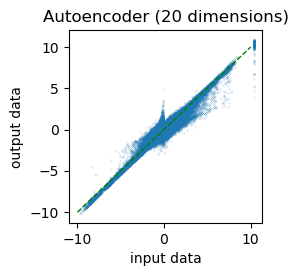

In [29]:
X_all_pred=model20dims.predict(dataX_log_del2,verbose=1)
plt.figure(figsize=(2.5,2.5))
plt.scatter(dataX_log_del2.to_numpy().reshape(-1),X_all_pred.reshape(-1), s=0.01)
plt.plot([-10,10],[-10,10], 'g--',linewidth=1.)
plt.title('Autoencoder (20 dimensions)')
plt.xlabel('input data')
plt.ylabel('output data')
print(f"pearson's correlation cefficient: {np.corrcoef(dataX_log_del2.to_numpy().reshape(-1),X_all_pred.reshape(-1))[0,1]}")

In [31]:
def correlation_coefficient(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
    return numerator / denominator

In [32]:
corr_coef_test = correlation_coefficient(df_test.values, X_test_pred)
print(corr_coef_test)

0.9877917766094358


In [33]:
corr_coef_tr = correlation_coefficient(df_train.values, X_train_pred)
print(corr_coef_tr)

0.9920659137328623


In [34]:
layer_name = 'dense_916'
latent_layer = Model(inputs = model20dims.input, outputs = model20dims.get_layer(layer_name).output)

In [35]:
latent_layer_pred_train = latent_layer.predict(df_train, verbose=1)

4/4 [==============================] - 0s 2ms/step


In [36]:
latent_layer_pred_train.shape

(102, 20)

In [37]:
latent_layer_pred_test=latent_layer.predict(df_test, verbose=1)

1/1 [==============================] - 0s 17ms/step


In [38]:
latent_layer_pred_test.shape

(6, 20)

In [39]:
X_train_20dims=pd.DataFrame(latent_layer_pred_train)
X_train_20dims

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-4.894204,4.146495,-10.627995,4.333094,-0.211089,-6.648520,-4.280519,-3.815852,-3.777365,-1.499009,-0.625212,-7.137741,-5.564987,1.921789,-6.913729,7.227826,-7.480397,-3.841025,-2.643135,-4.290059
1,-2.944945,-4.172675,2.317636,3.224382,2.160191,3.711342,5.053267,-7.703063,8.844687,-1.244160,0.254470,5.201087,-5.925610,4.695848,3.283216,-3.963865,5.261399,-4.708281,2.653075,-5.063646
2,5.588860,-0.694617,2.670450,-8.996168,-3.310686,-7.067754,3.733333,10.910929,2.443390,-4.109570,7.296700,6.122800,6.156366,-1.021480,3.269602,2.010873,1.207476,5.214314,6.464255,-2.690952
3,-7.072881,-4.657294,-6.835857,9.598818,1.465891,-5.823493,-5.777774,-7.312018,-0.630546,-6.401748,-6.745100,3.504016,4.543265,6.947121,8.620768,0.387783,-1.047444,3.723100,5.218976,4.335200
4,-5.568182,9.380668,7.979990,1.130456,5.788285,-3.061255,-3.599283,6.892598,2.539938,2.496101,-4.084094,8.950968,-4.972475,-5.133507,-7.145875,-4.389797,6.115207,-6.742897,5.260499,-5.494330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,3.891827,2.561099,6.970787,-7.018413,-5.253020,3.758243,3.671204,-10.044440,-7.940752,-0.323961,6.115371,-5.004793,1.852236,5.476236,-3.787934,-4.054970,2.748752,6.475208,0.135383,-7.873878
98,-7.752234,-4.231459,8.498736,-5.204750,-0.988339,2.461777,-1.641066,-7.762600,-0.770963,6.920038,-2.429935,-3.921720,-4.659022,-4.321660,2.040658,-4.948812,7.810775,-6.515944,4.377778,4.249447
99,5.738795,3.508221,-3.084219,-2.055181,-6.202135,-2.324691,-3.598113,-4.881999,4.343721,3.288866,-8.758722,-8.157871,-1.671575,-0.765159,-4.126219,5.952621,-7.953374,-6.093229,4.663666,4.219165
100,-1.368667,-3.972085,5.433074,6.601264,-6.426833,1.042758,4.944042,7.671537,-5.333508,-7.128211,-5.145265,1.020387,-3.897650,-7.551147,-4.268405,8.827366,-7.952704,4.574883,-4.473346,8.431083


In [40]:
X_test_20dims=pd.DataFrame(latent_layer_pred_test)
X_test_20dims

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-6.376636,6.685627,8.486855,-5.005437,0.986963,-2.510396,0.891873,-5.870406,-4.658065,5.980363,6.565961,-5.318729,-6.247756,-2.401874,-9.539203,4.514901,-6.644996,-1.029745,5.043787,-7.681988
1,3.641945,-7.661404,7.613710,-1.599616,7.090220,6.726690,-2.069273,-2.745076,2.530561,2.660381,7.137661,8.682987,6.308665,5.456786,8.533322,-3.954587,6.808384,-5.964357,-6.926980,-4.553753
2,3.359315,-4.861623,-5.498817,6.374908,1.541136,-6.441969,6.099424,5.147042,-2.580868,-4.977870,6.729605,-3.195096,5.148294,-4.076187,-7.195958,6.914922,-6.155535,4.881458,-7.642689,-8.291637
3,-0.756402,0.441134,-6.646461,1.472855,-6.947612,7.541595,4.625729,-6.928267,4.398932,1.071311,-1.451650,-5.603864,4.042096,-0.611265,-1.356958,-5.764071,-6.192120,-8.153080,-6.249497,5.730522
4,0.938262,-3.290774,6.039089,-9.971478,4.504210,-7.470418,-7.287096,-3.256257,-2.944622,1.461293,7.112204,5.424419,-4.540638,-0.372598,-7.300920,-0.119995,-5.317137,-6.542215,-6.035981,4.083077
5,-6.365646,8.686355,-3.822531,-7.310308,-3.612169,-2.193326,-4.453616,-3.896858,2.272247,3.491675,8.014971,-7.702356,1.721457,-6.695879,-4.547217,-7.225779,2.713670,4.677006,1.589107,-5.289326


In [41]:
X_train_20dims['patient number'] = X_train.iloc[:, -1].values

In [42]:
X_train_20dims

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,patient number
0,-4.894204,4.146495,-10.627995,4.333094,-0.211089,-6.648520,-4.280519,-3.815852,-3.777365,-1.499009,...,-7.137741,-5.564987,1.921789,-6.913729,7.227826,-7.480397,-3.841025,-2.643135,-4.290059,1
1,-2.944945,-4.172675,2.317636,3.224382,2.160191,3.711342,5.053267,-7.703063,8.844687,-1.244160,...,5.201087,-5.925610,4.695848,3.283216,-3.963865,5.261399,-4.708281,2.653075,-5.063646,0
2,5.588860,-0.694617,2.670450,-8.996168,-3.310686,-7.067754,3.733333,10.910929,2.443390,-4.109570,...,6.122800,6.156366,-1.021480,3.269602,2.010873,1.207476,5.214314,6.464255,-2.690952,2
3,-7.072881,-4.657294,-6.835857,9.598818,1.465891,-5.823493,-5.777774,-7.312018,-0.630546,-6.401748,...,3.504016,4.543265,6.947121,8.620768,0.387783,-1.047444,3.723100,5.218976,4.335200,1
4,-5.568182,9.380668,7.979990,1.130456,5.788285,-3.061255,-3.599283,6.892598,2.539938,2.496101,...,8.950968,-4.972475,-5.133507,-7.145875,-4.389797,6.115207,-6.742897,5.260499,-5.494330,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,3.891827,2.561099,6.970787,-7.018413,-5.253020,3.758243,3.671204,-10.044440,-7.940752,-0.323961,...,-5.004793,1.852236,5.476236,-3.787934,-4.054970,2.748752,6.475208,0.135383,-7.873878,2
98,-7.752234,-4.231459,8.498736,-5.204750,-0.988339,2.461777,-1.641066,-7.762600,-0.770963,6.920038,...,-3.921720,-4.659022,-4.321660,2.040658,-4.948812,7.810775,-6.515944,4.377778,4.249447,0
99,5.738795,3.508221,-3.084219,-2.055181,-6.202135,-2.324691,-3.598113,-4.881999,4.343721,3.288866,...,-8.157871,-1.671575,-0.765159,-4.126219,5.952621,-7.953374,-6.093229,4.663666,4.219165,1
100,-1.368667,-3.972085,5.433074,6.601264,-6.426833,1.042758,4.944042,7.671537,-5.333508,-7.128211,...,1.020387,-3.897650,-7.551147,-4.268405,8.827366,-7.952704,4.574883,-4.473346,8.431083,1


In [43]:
X_test_20dims['patient number'] = X_test.iloc[:, -1].values

In [44]:
X_test_20dims

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,patient number
0,-6.376636,6.685627,8.486855,-5.005437,0.986963,-2.510396,0.891873,-5.870406,-4.658065,5.980363,...,-5.318729,-6.247756,-2.401874,-9.539203,4.514901,-6.644996,-1.029745,5.043787,-7.681988,0
1,3.641945,-7.661404,7.613710,-1.599616,7.090220,6.726690,-2.069273,-2.745076,2.530561,2.660381,...,8.682987,6.308665,5.456786,8.533322,-3.954587,6.808384,-5.964357,-6.926980,-4.553753,0
2,3.359315,-4.861623,-5.498817,6.374908,1.541136,-6.441969,6.099424,5.147042,-2.580868,-4.977870,...,-3.195096,5.148294,-4.076187,-7.195958,6.914922,-6.155535,4.881458,-7.642689,-8.291637,2
3,-0.756402,0.441134,-6.646461,1.472855,-6.947612,7.541595,4.625729,-6.928267,4.398932,1.071311,...,-5.603864,4.042096,-0.611265,-1.356958,-5.764071,-6.192120,-8.153080,-6.249497,5.730522,1
4,0.938262,-3.290774,6.039089,-9.971478,4.504210,-7.470418,-7.287096,-3.256257,-2.944622,1.461293,...,5.424419,-4.540638,-0.372598,-7.300920,-0.119995,-5.317137,-6.542215,-6.035981,4.083077,1
5,-6.365646,8.686355,-3.822531,-7.310308,-3.612169,-2.193326,-4.453616,-3.896858,2.272247,3.491675,...,-7.702356,1.721457,-6.695879,-4.547217,-7.225779,2.713670,4.677006,1.589107,-5.289326,1


In [45]:
df_20dims=pd.concat([X_train_20dims, X_test_20dims], axis=0, ignore_index=True)
df_20dims

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,patient number
0,-4.894204,4.146495,-10.627995,4.333094,-0.211089,-6.648520,-4.280519,-3.815852,-3.777365,-1.499009,...,-7.137741,-5.564987,1.921789,-6.913729,7.227826,-7.480397,-3.841025,-2.643135,-4.290059,1
1,-2.944945,-4.172675,2.317636,3.224382,2.160191,3.711342,5.053267,-7.703063,8.844687,-1.244160,...,5.201087,-5.925610,4.695848,3.283216,-3.963865,5.261399,-4.708281,2.653075,-5.063646,0
2,5.588860,-0.694617,2.670450,-8.996168,-3.310686,-7.067754,3.733333,10.910929,2.443390,-4.109570,...,6.122800,6.156366,-1.021480,3.269602,2.010873,1.207476,5.214314,6.464255,-2.690952,2
3,-7.072881,-4.657294,-6.835857,9.598818,1.465891,-5.823493,-5.777774,-7.312018,-0.630546,-6.401748,...,3.504016,4.543265,6.947121,8.620768,0.387783,-1.047444,3.723100,5.218976,4.335200,1
4,-5.568182,9.380668,7.979990,1.130456,5.788285,-3.061255,-3.599283,6.892598,2.539938,2.496101,...,8.950968,-4.972475,-5.133507,-7.145875,-4.389797,6.115207,-6.742897,5.260499,-5.494330,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,3.641945,-7.661404,7.613710,-1.599616,7.090220,6.726690,-2.069273,-2.745076,2.530561,2.660381,...,8.682987,6.308665,5.456786,8.533322,-3.954587,6.808384,-5.964357,-6.926980,-4.553753,0
104,3.359315,-4.861623,-5.498817,6.374908,1.541136,-6.441969,6.099424,5.147042,-2.580868,-4.977870,...,-3.195096,5.148294,-4.076187,-7.195958,6.914922,-6.155535,4.881458,-7.642689,-8.291637,2
105,-0.756402,0.441134,-6.646461,1.472855,-6.947612,7.541595,4.625729,-6.928267,4.398932,1.071311,...,-5.603864,4.042096,-0.611265,-1.356958,-5.764071,-6.192120,-8.153080,-6.249497,5.730522,1
106,0.938262,-3.290774,6.039089,-9.971478,4.504210,-7.470418,-7.287096,-3.256257,-2.944622,1.461293,...,5.424419,-4.540638,-0.372598,-7.300920,-0.119995,-5.317137,-6.542215,-6.035981,4.083077,1


In [46]:
#importing library
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import pickle

In [47]:
# data split and standardalization
x_gbm = df_20dims.drop('patient number', axis = 1).values
y_gbm = df_20dims['patient number'].values
sc = StandardScaler()
sc.fit(x_gbm)
x_gbm = sc.transform(x_gbm)
x_train_gbm, x_test_gbm, y_train_gbm, y_test_gbm = train_test_split(x_gbm, y_gbm, test_size=0.05, shuffle = True, random_state=2022, stratify=y_gbm)

In [48]:
# parameters optimization using optuna
def objective(trial):
    # Set LightGBM hyperparameters using Optuna
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_class': 3,
        'num_iteration': 3000,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    }

    # Set 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state = 2022)

    # List to save cross-validation results
    cv_results = []

    # Train and evaluate the model for each fold
    for train_idx, valid_idx in cv.split(x_gbm, y_gbm):
        X_train, X_valid = x_gbm[train_idx], x_gbm[valid_idx]
        y_train, y_valid = y_gbm[train_idx], y_gbm[valid_idx]
        
        lgb_train = lgb.Dataset(X_train, label = y_train)
        lgb_valid = lgb.Dataset(X_valid, label = y_valid, reference = lgb_train)
        
        gbm = lgb.train(param,
                        lgb_train,
                        valid_sets = [lgb_train, lgb_valid],
                        early_stopping_rounds = 100,
                        verbose_eval = False)
        y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
        y_pred_max = np.argmax(y_pred, axis=1)
        cv_results.append(accuracy_score(y_valid, y_pred_max))

    # Return the minimum accuracy from cross-validation
    return np.mean(cv_results)

# Create an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2025-06-03 19:10:51,935] A new study created in memory with name: no-name-0ee7d3b8-3978-46fb-96db-d648640256ca
[I 2025-06-03 19:10:53,458] Trial 0 finished with value: 0.4636363636363637 and parameters: {'lambda_l1': 2.6384744630397656, 'lambda_l2': 0.02762937449326426, 'num_leaves': 206, 'feature_fraction': 0.9177831600428838, 'bagging_fraction': 0.42721506984231594, 'bagging_freq': 7, 'min_child_samples': 32, 'learning_rate': 0.004568831473223616}. Best is trial 0 with value: 0.4636363636363637.
[I 2025-06-03 19:11:10,419] Trial 1 finished with value: 0.4918181818181818 and parameters: {'lambda_l1': 8.792264477432843e-07, 'lambda_l2': 0.0001746525537886768, 'num_leaves': 48, 'feature_fraction': 0.9268279815768599, 'bagging_fraction': 0.8077929257748757, 'bagging_freq': 3, 'min_child_samples': 26, 'learning_rate': 0.00020761177351523699}. Best is trial 1 with value: 0.4918181818181818.
[I 2025-06-03 19:11:21,052] Trial 2 finished with value: 0.4636363636363637 and parameters: {'lam

Best trial:
  Value: 0.6681818181818182
  Params: 
    lambda_l1: 2.7311351914174614e-07
    lambda_l2: 0.0014335721349859238
    num_leaves: 131
    feature_fraction: 0.6328016413431138
    bagging_fraction: 0.6227639062577796
    bagging_freq: 5
    min_child_samples: 16
    learning_rate: 0.010175100821883753


In [98]:
from typing import Optional, List, Tuple
# multiclass_log_loss for LGBM 

class MultiLoglossForLGBM:
    
    def __init__(self, n_class: int=3, use_softmax: bool=True, epsilon: float=1e-32, grand_truth=np.empty(0)) -> None:
        # initialize        
        self.name = "SFC_loss"
        self.grand_truth = grand_truth
        self.n_class = n_class
        self.prob_func = self._get_prob_value if use_softmax else lambda x: x
        self.epsilon = epsilon
    
    def __call__(self, preds: np.ndarray, labels: np.ndarray, weight: Optional[np.ndarray]=None) -> float:
        #calculate loss function
        #get prob value by softmax
        prob = self.prob_func(preds)           # <= from logits to probability
        #convert labels to 1-hot
        labels = self._get_1hot_label(labels)  # <= labels (1D-array) to 1hot
        loss_by_sample = np.sum(- np.log(prob) * labels, axis=1)
        loss = np.average(loss_by_sample, weight)
        
        return loss
    
    def _calc_grad_and_hess(
        self, preds: np.ndarray, labels: np.ndarray, weight: Optional[np.ndarray]=None
    ) -> Tuple[np.ndarray]:
        """Calc Grad and Hess"""
        # # get prob value by softmax
        prob = self.prob_func(preds)           # <= margin を確率値に直す
        # # convert labels to 1-hot
        labels = self._get_1hot_label(labels)  # <= labels (1D-array) to 1hot label

        grad = prob - labels
        hess = prob * (1 - prob)        
        if weight is not None:
            grad = grad * weight[:, None]
            hess = hess * weight[:, None]
        return grad, hess
    
    def return_loss(self, preds: np.ndarray, data: lgb.Dataset) -> Tuple[str, float, bool]:
        """Return Loss for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T  # <= preds (1D-array) to 2D-array 
        # # calc loss
        loss = self(preds, labels, weight)
        
        return self.name, loss, False
    
    def return_grad_and_hess(self, preds: np.ndarray, data: lgb.Dataset) -> Tuple[np.ndarray]:
        """Return Grad and Hess for lightgbm"""
        labels = data.get_label()
        weight = data.get_weight()
        n_example = len(labels)
        
        # # reshape preds: (n_class * n_example,) => (n_class, n_example) =>  (n_example, n_class)
        preds = preds.reshape(self.n_class, n_example).T  # <= preds (1D-array) to 2D-array 
        # # calc grad and hess.
        grad, hess =  self._calc_grad_and_hess(preds, labels, weight)

        # # reshape grad, hess: (n_example, n_class) => (n_class, n_example) => (n_class * n_example,) 
        grad = grad.T.reshape(n_example * self.n_class)   # <= return 1D-array 
        hess = hess.T.reshape(n_example * self.n_class)   # <= return 1D-array 
        
        return grad, hess
    
    def softmax(x):
        return np.exp(x)/np.sum(np.exp(x))
    
    def _get_prob_value(self, preds: np.ndarray) -> np.ndarray:
        """Convert Margin(Logit) to Prob by Softmax."""
        upper = np.exp(preds)
        prob = upper / np.sum(upper, axis=1, keepdims=True)
        prob = np.clip(prob, self.epsilon, 1 - self.epsilon)
        
        return prob
    
    
    def _get_1hot_label(self, labels: np.ndarray) -> np.ndarray:
        """Convert labels to 1hot array."""
        n_example = len(labels)
        #make a matrix here
        onehot = np.zeros((n_example, self.n_class))
        #setting overlap
        original_array=self.grand_truth
        for index, j in enumerate(labels):
            if self.grand_truth.shape[0]==0:
                onehot[index, int(j)] =1
            else:
                onehot[index,:]=original_array[int(j)]
        return onehot

In [ ]:
# cross validation 
best_params_GC = trial.params
best_params_GC.update({
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_class': 3,
    'num_iteration': 3000,
    'verbosity': -1,
    'early_stopping_rounds': 100,
    'importance_type': 'gain',
    'seed': 42
})

# params in SFC
best_params_SFC = trial.params.copy()
best_params_SFC.update({
    'objective': 'multiclass',
    'metric': 'none',
    'boosting_type': 'gbdt',
    'num_class': 3,
    'num_iteration': 3000,
    'verbosity': -1,
    'early_stopping_rounds': 100,
    'seed': 42
})



# divide dataset
n_splits = 10
cv = list(StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 2022).split(x_gbm, y_gbm))
feature_names = [f"feature{i+1}" for i in range(x_gbm.shape[1])]
CV_names = [f"CV{i}" for i in range(n_splits)]
overlap_w_list = [0.01, 0.025, 0.05, 0.075, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5]
df_importance_Diff_rank_ol_sensitivity = pd.DataFrame(columns = overlap_w_list, index = feature_names)

for ol_id, overlap_w in enumerate(overlap_w_list):
    df_acc = pd.DataFrame(columns=CV_names, index=['GC','SFC'])
    df_importance_GC = pd.DataFrame(columns=CV_names, index=feature_names)
    df_importance_SFC = pd.DataFrame(columns=CV_names, index=feature_names)
    df_importance_Diff = pd.DataFrame(columns=CV_names, index=feature_names)
    df_importance_Diff_rank = pd.DataFrame(index = df_importance_Diff.index)

    # labeling
    grand_truth_SFC = np.array([[1.-overlap_w,overlap_w,0],[overlap_w,1.-2*overlap_w,overlap_w],[0,overlap_w,1.-overlap_w]])
    print( grand_truth_SFC)

    # CV loop
    for nfold, (train_index, valid_index) in enumerate(cv):
        print("-"*20, nfold, "-"*20)
        x_tr, y_tr = x_gbm[train_index], y_gbm[train_index]
        x_va, y_va = x_gbm[valid_index], y_gbm[valid_index]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)

        # define lgb dataset
        lgb_train = lgb.Dataset(x_tr, label = y_tr)
        lgb_eval = lgb.Dataset(x_va, label = y_va, reference = lgb_train)

        print("\n")
        print("-"*20, "GC model learning", "-"*20, "\n")


        # model training
        evaluation_results={}
        model_GC = lgb.train(best_params_GC,
                          train_set=lgb_train,
                          valid_names=['train', 'valid'],
                          valid_sets=[lgb_train, lgb_eval],
                          evals_result=evaluation_results,
                          early_stopping_rounds = 100
                         )

        # calculate accuracy of test data
        y_pred_prob = model_GC.predict(x_va, num_iteration = model_GC.best_iteration)
        y_pred_GC = np.argmax(y_pred_prob,axis=1)
        acc_GC = accuracy_score(y_va, y_pred_GC)
        print("-"*20, "Test data accuracy", "-"*20, "\n")
        print(acc_GC)


        # model training
        print("\n")
        print("-"*20, "SFC model learning", "-"*20, "\n")
        evaluation_results2={}

        SFC_loss = MultiLoglossForLGBM(n_class = 3, grand_truth=grand_truth_SFC, use_softmax = True)
        model_SFC = lgb.train(best_params_SFC,
                                    train_set=lgb_train,
                                    valid_names=['train', 'valid'],
                                    valid_sets=[lgb_train, lgb_eval],
                                    evals_result=evaluation_results2,
                                    fobj=SFC_loss.return_grad_and_hess,
                                    feval=lambda preds, data: SFC_loss.return_loss(preds, data),
                                    early_stopping_rounds = 100
                                   )

        # calculate accuracy of test data
        y_pred_prob_SFC = model_SFC.predict(x_va, num_iteration = model_SFC.best_iteration)
        y_pred_SFC = np.argmax(y_pred_prob_SFC,axis=1)
        acc_SFC = accuracy_score(y_va, y_pred_SFC)
        print("-"*20, "Test data accuracy", "-"*20, "\n")
        print(acc_SFC)

        # print("-"*20, "gain importance in GC", "-"*20, "\n")
        # print(df_importance)

        # gain features
        cols = list(df_20dims.drop('patient number', axis = 1).columns)

        # calculate differences between GC and SFC
        f_importance_GC = np.array(model_GC.feature_importance(importance_type='gain'))
        f_importance_GC = f_importance_GC / np.sum(f_importance_GC)
        f_importance_SFC = np.array(model_SFC.feature_importance(importance_type='gain'))
        f_importance_SFC = f_importance_SFC / np.sum(f_importance_SFC)
        # after - before gain
        df_importance_subtracted = f_importance_SFC - f_importance_GC
        df_importance_subtracted = df_importance_subtracted / np.sum(np.abs(df_importance_subtracted))
        df_importance_subtracted = pd.DataFrame({'feature':feature_names , 'importance':df_importance_subtracted})
        # df_importance_subtracted = df_importance_subtracted.sort_values('importance', ascending=False)
        print("-"*20, "Difference of importance", "-"*20, "\n")

        print(df_importance_subtracted)
        df_acc.at['GC',CV_names[nfold]] = acc_GC
        df_acc.at['SFC',CV_names[nfold]] = acc_SFC
        df_importance_GC[CV_names[nfold]] = f_importance_SFC
        df_importance_SFC[CV_names[nfold]] = f_importance_SFC
        df_importance_Diff[CV_names[nfold]] = f_importance_SFC - f_importance_GC

    acc_th = 2./3.
    df_acc.loc[:,(df_acc>=acc_th).sum(axis=0)==2]
    for col in df_importance_Diff.columns:
        rank = df_importance_Diff[col].rank(method="min" , ascending=False)
        df_importance_Diff_rank[col] = rank
    df_importance_Diff_rank['rank_sum']=df_importance_Diff_rank.loc[:,(df_acc>=acc_th).sum(axis=0)==2].sum(axis=1)
    df_importance_Diff_rank_ol_sensitivity[overlap_w]=df_importance_Diff_rank['rank_sum'].copy()

    file_name='revise_250603_calc_log_overlap_id_'+str(ol_id)+'.pkl'
    with open(file_name,'wb') as f:
        pickle.dump([model_GC,model_SFC, df_acc,df_importance_GC,df_importance_SFC,df_importance_Diff,df_importance_Diff_rank], f)
    del df_acc,df_importance_GC,df_importance_SFC,df_importance_Diff,df_importance_Diff_rank

[[0.99 0.01 0.  ]
 [0.01 0.98 0.01]
 [0.   0.01 0.99]]
-------------------- 0 --------------------
(97, 20) (97,)
(11, 20) (11,)


-------------------- GC model learning -------------------- 

[LightGBM] [Warning] Unknown parameter: importance_type
[1]	train's multi_logloss: 1.0579	valid's multi_logloss: 1.0629
Training until validation scores don't improve for 100 rounds
[2]	train's multi_logloss: 1.05439	valid's multi_logloss: 1.06299
[3]	train's multi_logloss: 1.05121	valid's multi_logloss: 1.05944
[4]	train's multi_logloss: 1.04779	valid's multi_logloss: 1.05866
[5]	train's multi_logloss: 1.04472	valid's multi_logloss: 1.05578
[6]	train's multi_logloss: 1.04058	valid's multi_logloss: 1.05157
[7]	train's multi_logloss: 1.03664	valid's multi_logloss: 1.0463
[8]	train's multi_logloss: 1.03318	valid's multi_logloss: 1.04168
[9]	train's multi_logloss: 1.03007	valid's multi_logloss: 1.04009
[10]	train's multi_logloss: 1.02676	valid's multi_logloss: 1.03542
[11]	train's multi_logloss: 1.0

In [114]:
df_importance_Diff_rank_ol_sensitivity

,0.010,0.025,0.050,0.075,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,0.500
feature1,50.0,53.0,51.0,61.0,62.0,46.0,43.0,49.0,33.0,0.0,0.0,0.0,0.0
feature2,64.0,55.0,53.0,45.0,34.0,20.0,21.0,23.0,15.0,0.0,0.0,0.0,0.0
feature3,67.0,78.0,62.0,81.0,86.0,59.0,59.0,58.0,40.0,0.0,0.0,0.0,0.0
feature4,61.0,52.0,59.0,54.0,54.0,31.0,30.0,32.0,23.0,0.0,0.0,0.0,0.0
feature5,38.0,38.0,52.0,33.0,32.0,20.0,28.0,26.0,17.0,0.0,0.0,0.0,0.0
feature6,55.0,59.0,70.0,68.0,70.0,35.0,34.0,35.0,24.0,0.0,0.0,0.0,0.0
feature7,59.0,58.0,69.0,69.0,73.0,46.0,48.0,46.0,30.0,0.0,0.0,0.0,0.0
feature8,48.0,60.0,64.0,62.0,73.0,44.0,44.0,42.0,23.0,0.0,0.0,0.0,0.0
feature9,51.0,58.0,24.0,30.0,25.0,9.0,7.0,7.0,6.0,0.0,0.0,0.0,0.0
feature10,61.0,63.0,68.0,64.0,68.0,39.0,36.0,32.0,20.0,0.0,0.0,0.0,0.0


In [115]:
df_importance_Diff_rank_ol_sensitivity/df_importance_Diff_rank_ol_sensitivity.sum(axis=0)

,0.010,0.025,0.050,0.075,0.100,0.150,0.200,0.250,0.300,0.350,0.400,0.450,0.500
feature1,0.047619,0.050476,0.048571,0.058095,0.059048,0.073016,0.068254,0.077778,0.078571,NaN,NaN,NaN,NaN
feature2,0.060952,0.052381,0.050476,0.042857,0.032381,0.031746,0.033333,0.036508,0.035714,NaN,NaN,NaN,NaN
feature3,0.063810,0.074286,0.059048,0.077143,0.081905,0.093651,0.093651,0.092063,0.095238,NaN,NaN,NaN,NaN
feature4,0.058095,0.049524,0.056190,0.051429,0.051429,0.049206,0.047619,0.050794,0.054762,NaN,NaN,NaN,NaN
feature5,0.036190,0.036190,0.049524,0.031429,0.030476,0.031746,0.044444,0.041270,0.040476,NaN,NaN,NaN,NaN
feature6,0.052381,0.056190,0.066667,0.064762,0.066667,0.055556,0.053968,0.055556,0.057143,NaN,NaN,NaN,NaN
feature7,0.056190,0.055238,0.065714,0.065714,0.069524,0.073016,0.076190,0.073016,0.071429,NaN,NaN,NaN,NaN
feature8,0.045714,0.057143,0.060952,0.059048,0.069524,0.069841,0.069841,0.066667,0.054762,NaN,NaN,NaN,NaN
feature9,0.048571,0.055238,0.022857,0.028571,0.023810,0.014286,0.011111,0.011111,0.014286,NaN,NaN,NaN,NaN
feature10,0.058095,0.060000,0.064762,0.060952,0.064762,0.061905,0.057143,0.050794,0.047619,NaN,NaN,NaN,NaN


In [138]:
df_importance_Diff_percentile_ol_sensitivity=((df_importance_Diff_rank_ol_sensitivity-df_importance_Diff_rank_ol_sensitivity.min(axis=0))/
                                              (df_importance_Diff_rank_ol_sensitivity.max(axis=0)-
                                              df_importance_Diff_rank_ol_sensitivity.min(axis=0))).iloc[:,:9]

In [139]:
df_importance_Diff_percentile_ol_sensitivity2=df_importance_Diff_percentile_ol_sensitivity.copy()

In [140]:
df_importance_Diff_percentile_ol_sensitivity2['mean']=df_importance_Diff_percentile_ol_sensitivity.mean(axis=1)

In [141]:
df_importance_Diff_percentile_ol_sensitivity2.sort_values('mean')

,0.01,0.025,0.05,0.075,0.1,0.15,0.2,0.25,0.3,mean
feature16,0.309091,0.098039,0.037736,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.055602
feature18,0.272727,0.137255,0.056604,0.016393,0.000000,0.037037,0.037037,0.018868,0.000000,0.063991
feature9,0.545455,0.568627,0.000000,0.016393,0.055556,0.074074,0.037037,0.018868,0.055556,0.152396
feature19,0.000000,0.117647,0.075472,0.196721,0.236111,0.351852,0.259259,0.226415,0.222222,0.187300
feature11,0.236364,0.000000,0.283019,0.049180,0.208333,0.314815,0.333333,0.377358,0.388889,0.243477
feature17,0.545455,0.235294,0.301887,0.049180,0.097222,0.296296,0.277778,0.245283,0.277778,0.258464
feature5,0.309091,0.176471,0.528302,0.065574,0.152778,0.277778,0.425926,0.377358,0.361111,0.297154
feature13,0.436364,0.215686,0.490566,0.180328,0.208333,0.351852,0.462963,0.415094,0.361111,0.346922
feature2,0.781818,0.509804,0.547170,0.262295,0.180556,0.277778,0.296296,0.320755,0.305556,0.386892
feature14,0.618182,0.196078,0.698113,0.377049,0.375000,0.333333,0.444444,0.433962,0.500000,0.441796


In [122]:
import seaborn as sns

Text(50.722222222222214, 0.5, 'feature')

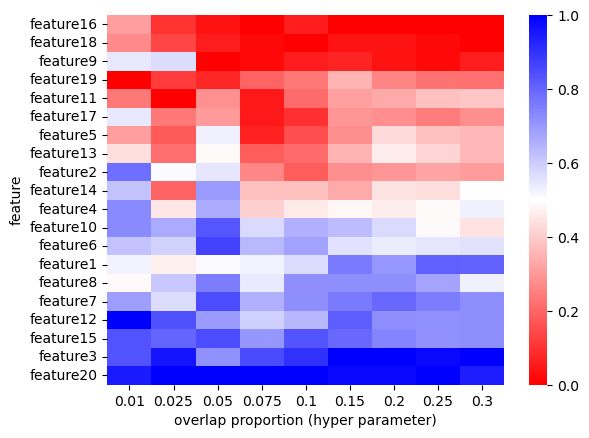

In [148]:
sns.heatmap(df_importance_Diff_percentile_ol_sensitivity2.sort_values('mean').iloc[:,:-1], cmap='bwr_r')
plt.xlabel('overlap proportion (hyper parameter)')
plt.ylabel('feature')

In [145]:
file_name='revise_250603_overlap_sensitivity.pkl'
with open(file_name,'wb') as f:
    pickle.dump([df_importance_Diff_percentile_ol_sensitivity,df_importance_Diff_percentile_ol_sensitivity2], f)

In [149]:
!jupyter nbconvert --to html Revise_PD_HD_20dim_classification_CV10_optimized_ol_sensitivity.ipynb

[NbConvertApp] Converting notebook Revise_PD_HD_20dim_classification_CV10_optimized_ol_sensitivity.ipynb to html
[NbConvertApp] Writing 1973879 bytes to Revise_PD_HD_20dim_classification_CV10_optimized_ol_sensitivity.html
